In [1]:
%matplotlib inline
import csv
import itertools
import multiprocessing
import os
import struct
import traceback
from concurrent.futures import ThreadPoolExecutor
from urllib.request import urlopen

import tensorflow as tf
from IPython.display import clear_output
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import Sequence, multi_gpu_model
from skimage.io import imread, imsave
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

assert tf.test.is_gpu_available()

Using TensorFlow backend.


In [2]:
image_size = 224
behaviours = ['eating', 'resting', 'grooming', 'running', 'sleeping', 'walking', 'swimming']

In [126]:
def get_random_transform(rotation_deg_sigma=15):
    flip_horizontal = np.random.rand() < 0.5
    
    rotation_deg = np.random.randn() * rotation_deg_sigma
    
    return {
        'flip_horizontal': flip_horizontal,
        'rotation_deg': rotation_deg,
    }

def apply_transform(frame, params, *, sigma=0.05):
    for c in range(frame.shape[2]):
        frame[:, :, c] = rotate(frame[:, :, c], params['rotation_deg'], mode='reflect')

    if params['flip_horizontal']:
        frame = frame[:, ::-1]

    frame = frame.astype(float) + np.random.randn(*frame.shape) * sigma
    frame = np.clip(frame, 0, 1)
    
    return frame

In [14]:
import hashlib
import random

def generate_batches(batch_size, want_val):
    if not want_val:
        np.random.seed(struct.unpack('I', os.urandom(4)))
        random.seed(struct.unpack('I', os.urandom(4)))
    else:
        np.random.seed(42)
        random.seed(42)
    
    while True:
        X_batch = []
        y_batch = []
        for _ in range(batch_size):
            while True:
                beh_index = np.random.randint(len(behaviours))
                beh = behaviours[beh_index]
                filename = random.choice(sorted(os.listdir('crops/tiger_{}'.format(beh))))

                is_val = hashlib.sha1(filename.encode()).hexdigest()[-1] in 'ef'
                if want_val != is_val:
                    continue

                try:
                    image = imread('crops/tiger_{}/{}'.format(beh, filename))
                except Exception as e:
                    continue

                image = resize(image, (image_size, image_size))

                if image.shape == (image_size, image_size, 4):
                    image = image[:, :, :3]
                if image.shape == (image_size, image_size):
                    image = np.dstack([image] * 3)
                    
                if not want_val:
                    params = get_random_transform()
                    image = apply_transform(image, params)

                output = np.zeros(len(behaviours))
                output[beh_index] = 1

                X_batch.append(image)
                y_batch.append(output)
                break
            
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        yield X_batch, y_batch

In [125]:
def build_model():
    spatial = MobileNetV2(input_shape=(image_size, image_size, 3),
                        alpha=1.4, weights='imagenet', include_top=False)
    for layer in spatial.layers:
        name = layer.name
#         if not (name.startswith('block_15') or name.startswith('block_16') or
#                 name in ['Conv_1', 'Conv_1_bn', 'out_relu']):
#             layer.trainable = False
        
    x = GlobalAveragePooling2D()(spatial.output)
#     x = Dropout(0.1)(x)
    
    output = Dense(len(behaviours), activation='softmax', name='spatial_output')(x)
    
    model = Model(inputs=[spatial.input], outputs=[output])
    return model

model = build_model()

In [127]:
optimizer = SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

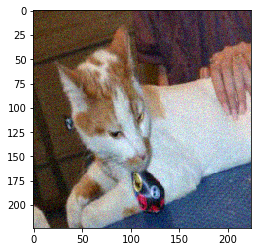

In [128]:
import matplotlib.pyplot as plt

plt.imshow(next(generate_batches(4, want_val=False))[0][2])

In [ ]:
batch_size = 4
model.fit_generator(generate_batches(batch_size, want_val=False),
                    steps_per_epoch=1000,
                    validation_data=generate_batches(batch_size, want_val=True),
                    validation_steps=200,
                    epochs=70,
                    workers=multiprocessing.cpu_count() - 1,
                    use_multiprocessing=True)

Epoch 1/70
1000/1000 [==============================] - 131s 131ms/step - loss: 1.6147 - acc: 0.4073 - val_loss: 2.2396 - val_acc: 0.3500
Epoch 2/70
1000/1000 [==============================] - 115s 115ms/step - loss: 1.3042 - acc: 0.5312 - val_loss: 1.8681 - val_acc: 0.4050
Epoch 3/70
1000/1000 [==============================] - 115s 115ms/step - loss: 1.1506 - acc: 0.5905 - val_loss: 1.2703 - val_acc: 0.5950
Epoch 4/70
1000/1000 [==============================] - 115s 115ms/step - loss: 1.0209 - acc: 0.6445 - val_loss: 1.9934 - val_acc: 0.4300
Epoch 5/70
1000/1000 [==============================] - 115s 115ms/step - loss: 0.9338 - acc: 0.6788 - val_loss: 1.0691 - val_acc: 0.6362
Epoch 6/70
1000/1000 [==============================] - 115s 115ms/step - loss: 0.8791 - acc: 0.6980 - val_loss: 1.5345 - val_acc: 0.5750
Epoch 7/70
1000/1000 [==============================] - 115s 115ms/step - loss: 0.8139 - acc: 0.7147 - val_loss: 1.1689 - val_acc: 0.6275
Epoch 8/70
1000/1000 [============

In [ ]:
# Old

In [21]:
for layer in model.layers:
    layer.trainable = True

optimizer = SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 4
model.fit_generator(generate_batches(batch_size, want_val=False),
                    steps_per_epoch=1000,
                    validation_data=generate_batches(batch_size, want_val=True),
                    validation_steps=200,
                    epochs=30,
                    workers=multiprocessing.cpu_count() - 1,
                    use_multiprocessing=True)

Epoch 1/30
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0702 - acc: 0.9745 - val_loss: 0.6601 - val_acc: 0.8500
Epoch 2/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0638 - acc: 0.9768 - val_loss: 0.7454 - val_acc: 0.8213
Epoch 3/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0645 - acc: 0.9742 - val_loss: 0.7440 - val_acc: 0.8313
Epoch 4/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0608 - acc: 0.9755 - val_loss: 0.9220 - val_acc: 0.8163
Epoch 5/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0552 - acc: 0.9768 - val_loss: 0.7579 - val_acc: 0.8650
Epoch 6/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0559 - acc: 0.9748 - val_loss: 1.4413 - val_acc: 0.7500
Epoch 7/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0469 - acc: 0.9802 - val_loss: 0.8204 - val_acc: 0.8363
Epoch 8/30
1000/1000 [==========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 92s 92ms/step - loss: 0.0510 - acc: 0.9782 - val_loss: 0.9924 - val_acc: 0.7937
Epoch 21/30
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0454 - acc: 0.9835 - val_loss: 0.7793 - val_acc: 0.8075
Epoch 22/30
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0455 - acc: 0.9815 - val_loss: 1.2109 - val_acc: 0.8087
Epoch 23/30
 386/1000 [==========>...................] - ETA: 52s - loss: 0.0414 - acc: 0.9806

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
model.save('model_v4_dropout0.h5')

In [ ]:
def build_model():
    spatial = MobileNetV2(input_shape=(image_size, image_size, 3),
                        alpha=1.0, weights='imagenet', include_top=False)
#     for layer in spatial.layers:
#         name = layer.name
#         if not (name.startswith('block_15') or name.startswith('block_16') or
#                 name in ['Conv_1', 'Conv_1_bn', 'out_relu']):
#             layer.trainable = False
        
    x = GlobalAveragePooling2D()(spatial.output)
    x = Dropout(0.2)(x)
    
    output = Dense(len(behaviours), activation='softmax', name='spatial_output')(x)
    
    model = Model(inputs=[spatial.input], outputs=[output])
    return model

model = build_model()

optimizer = SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 4
model.fit_generator(generate_batches(batch_size, want_val=False),
                    steps_per_epoch=1000,
                    validation_data=generate_batches(batch_size, want_val=True),
                    validation_steps=200,
                    epochs=70,
                    workers=multiprocessing.cpu_count() - 1,
                    use_multiprocessing=True)

model.save('model_v4_dropout0_2.h5')

Epoch 1/70
Epoch 1/70
1000/1000 [==============================] - 96s 96ms/step - loss: 1.0359 - acc: 0.6398 - val_loss: 1.5659 - val_acc: 0.5150
Epoch 3/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.9049 - acc: 0.6900 - val_loss: 1.2104 - val_acc: 0.6125
Epoch 4/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.7692 - acc: 0.7365 - val_loss: 1.2346 - val_acc: 0.5800
Epoch 5/70
 243/1000 [======>.......................] - ETA: 1:07 - loss: 0.6972 - acc: 0.7757

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 96s 96ms/step - loss: 0.4174 - acc: 0.8580 - val_loss: 0.9978 - val_acc: 0.6787
Epoch 10/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3720 - acc: 0.8722 - val_loss: 1.5043 - val_acc: 0.6075
Epoch 11/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3291 - acc: 0.8898 - val_loss: 0.8970 - val_acc: 0.7013
Epoch 12/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3240 - acc: 0.8945 - val_loss: 1.0441 - val_acc: 0.6887
Epoch 13/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2774 - acc: 0.9060 - val_loss: 1.0955 - val_acc: 0.7800
Epoch 14/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2455 - acc: 0.9180 - val_loss: 0.9645 - val_acc: 0.7775
Epoch 15/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2401 - acc: 0.9185 - val_loss: 0.8007 - val_acc: 0.7612
Epoch 16/70
1000/1000 [==============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 96s 96ms/step - loss: 0.1151 - acc: 0.9612 - val_loss: 0.9550 - val_acc: 0.8187
Epoch 27/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0989 - acc: 0.9647 - val_loss: 1.0053 - val_acc: 0.7875
Epoch 28/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.1027 - acc: 0.9645 - val_loss: 0.6650 - val_acc: 0.8425
Epoch 29/70
 429/1000 [===========>..................] - ETA: 51s - loss: 0.1140 - acc: 0.9610

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 97s 97ms/step - loss: 0.0748 - acc: 0.9735 - val_loss: 0.7469 - val_acc: 0.8200
Epoch 34/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0862 - acc: 0.9700 - val_loss: 0.9413 - val_acc: 0.7925
Epoch 35/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0754 - acc: 0.9710 - val_loss: 1.0755 - val_acc: 0.7863
Epoch 36/70
 496/1000 [=============>................] - ETA: 45s - loss: 0.0568 - acc: 0.9798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 96s 96ms/step - loss: 0.0694 - acc: 0.9728 - val_loss: 0.5725 - val_acc: 0.8725
Epoch 41/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0720 - acc: 0.9742 - val_loss: 0.4893 - val_acc: 0.8588
Epoch 42/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0614 - acc: 0.9770 - val_loss: 1.1068 - val_acc: 0.7575
Epoch 43/70
 184/1000 [====>.........................] - ETA: 1:12 - loss: 0.0850 - acc: 0.9620

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 96s 96ms/step - loss: 0.0674 - acc: 0.9757 - val_loss: 0.7619 - val_acc: 0.8300
Epoch 48/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0669 - acc: 0.9780 - val_loss: 1.1408 - val_acc: 0.7662
Epoch 49/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0593 - acc: 0.9765 - val_loss: 0.8317 - val_acc: 0.8037
Epoch 50/70
 224/1000 [=====>........................] - ETA: 1:09 - loss: 0.0766 - acc: 0.9688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 96s 96ms/step - loss: 0.0546 - acc: 0.9765 - val_loss: 1.0946 - val_acc: 0.7863
Epoch 55/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0458 - acc: 0.9795 - val_loss: 1.1840 - val_acc: 0.7925
Epoch 56/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0471 - acc: 0.9780 - val_loss: 1.0287 - val_acc: 0.8025
Epoch 57/70
 268/1000 [=======>......................] - ETA: 1:05 - loss: 0.0381 - acc: 0.9795

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 97s 97ms/step - loss: 0.0477 - acc: 0.9778 - val_loss: 0.9468 - val_acc: 0.8000
Epoch 59/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0503 - acc: 0.9773 - val_loss: 0.8661 - val_acc: 0.8500
Epoch 60/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0465 - acc: 0.9798 - val_loss: 0.9817 - val_acc: 0.8075
Epoch 61/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0410 - acc: 0.9798 - val_loss: 1.2802 - val_acc: 0.7925
Epoch 62/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0435 - acc: 0.9813 - val_loss: 0.8713 - val_acc: 0.8475
Epoch 63/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0392 - acc: 0.9810 - val_loss: 0.9113 - val_acc: 0.8575
Epoch 64/70
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0453 - acc: 0.9792 - val_loss: 0.9537 - val_acc: 0.8113
Epoch 65/70
1000/1000 [==============================

In [29]:
from keras.models import load_model

model = load_model('model_v4_dropout0.h5')
# model_v4_dropout0.h5
model.fit_generator(generate_batches(batch_size, want_val=False),
                    steps_per_epoch=1,
                    validation_data=generate_batches(batch_size, want_val=True),
                    validation_steps=200,
                    epochs=1,
                    workers=multiprocessing.cpu_count() - 1,
                    use_multiprocessing=True)

Epoch 1/1Epoch 1/1

/anaconda/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/anaconda/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1/1 [==============================] - 16s 16s/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.0022 - val_acc: 0.7762


In [28]:
# model_v4_dropout0_1.h5
model.fit_generator(generate_batches(batch_size, want_val=False),
                    steps_per_epoch=1,
                    validation_data=generate_batches(batch_size, want_val=True),
                    validation_steps=200,
                    epochs=1,
                    workers=multiprocessing.cpu_count() - 1,
                    use_multiprocessing=True)

Epoch 1/1
Epoch 1/1
1/1 [==============================] - 7s 7s/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.9442 - val_acc: 0.8363


In [ ]:
# TODO: Check quality of model_v4_dropout0.h5 AND model_v4_dropout0_1.h5 on val
# TODO: Check the confusion matrix
# TODO: Augment!

# Old

# TODO: Merge ... and ...
# TODO: Remove duplicates

In [61]:
y_pred = model.predict(X_val, batch_size=4)

In [67]:
np.argmax(y_pred, axis=1)

array([1, 3, 0, 0, 3, 1, 4, 0, 0, 1, 4, 1, 0, 0, 4, 3, 4, 0, 4, 4, 0, 4,
       0, 0, 0, 4, 1, 4, 4, 2, 0, 0, 1, 0, 4, 1, 1, 3, 1, 0, 0, 0, 3, 4,
       4, 4, 3, 2, 0, 1, 0, 0, 4, 0, 0, 2, 4, 4, 3, 4, 0, 1, 3, 1, 4, 4,
       1, 0, 0, 1, 1, 0, 3, 0, 0, 4, 4, 4, 1, 4, 1, 3, 4, 0, 0, 3, 4, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 3, 3, 0, 4, 4, 1, 3, 0, 0, 0, 0, 0, 4,
       0, 1, 4, 0, 1, 0, 1, 1, 0, 3, 3, 0, 3, 4, 4, 0, 0, 4, 4, 0, 0, 0,
       3, 4, 0, 4, 1, 1])

In [70]:
(np.argmax(y_val, axis=1) == np.argmax(y_pred, axis=1)).mean()

0.5797101449275363

In [75]:
from sklearn.metrics import confusion_matrix

confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[25,  4,  0,  1,  5],
       [ 5, 21,  0,  2,  0],
       [10,  2,  3,  5,  8],
       [ 5,  3,  0,  8,  0],
       [ 6,  0,  0,  2, 23]])